# Inferring an Approval Rating with Bernoulli Sampling
$$
\newcommand{\Bern}{\mathrm{Bern}}
\newcommand{\Bin}{\mathrm{Bin}}
\newcommand{\E}{\mathbb{E}}
\newcommand{\Var}{\mathrm{Var}}
\newcommand{\phat}{\widehat{p}}
\newcommand{\zalpha}{z_{1-\alpha/2}}
$$
This notebook illustrates a simple model for estimating an approval rating (a population proportion) using a **Bernoulli** random variable model, simulated survey responses, and two kinds of confidence intervals:

- **Exact (Binomial) confidence interval** (via an exact binomial inversion / Clopper–Pearson style interval)
- **Central Limit Theorem (Normal approximation) confidence interval** (Wald interval)

> **Key idea:** If each respondent answers **Yes** (approve) / **No** (disapprove), we can model each response as a Bernoulli random variable  
$$
Y_i \sim \Bern(p),\quad i=1,\dots,n,
$$
where $p = \mu$ is the (unknown) approval probability in the population.

We estimate $p$ with the sample proportion
$$
\phat = \frac{1}{n}\sum_{i=1}^n Y_i.
$$


In [1]:
# ----- Standard packages -----
import sys, math, time
from pathlib import Path

import numpy as np
from numpy.linalg import norm
import matplotlib.pyplot as plt

import scipy as sp
import scipy.stats as stats
import pandas as pd

from typing import Callable, Dict, Any
from tqdm.auto import tqdm
from IPython.display import display, Markdown

if not hasattr(np, "math"):
    np.math = math

# ----- Reproducibility -----
rng = np.random.default_rng(20251222)

# ----- Import classlib: rely on env, but verify path -----
import classlib as cl
print("classlib path:", cl.__file__)

# ----- Optional: QMCPy + classlib generators (safe even if not used here) -----
try:
    import qmcpy as qp
    print("QMCPy version:", qp.__version__)

    qp.Kronecker = cl.generators.Kronecker
    qp.TensorProductGrid = cl.generators.TensorProductGrid
except Exception as e:
    qp = None
    print("QMCPy not available (ok for non-QMC notebooks):", repr(e))

# ----- Plotting / Style -----
%matplotlib inline

cl.nbviz.init(use_tex=True)
colors, TINY = cl.nbviz.TOL_BRIGHT, cl.nbviz.TINY
cl.nbviz.configure(figpath="approval_rating_figures", savefigs=True)

display(Markdown("All classes from `classlib` are accessed as `cl.*`" + ("" if qp is None else " and from `qmcpy` as `qp.*`.")))

classlib path: /Users/fredhickernell/SoftwareRepositories/HickernellClassLib/classlib/__init__.py
QMCPy version: 2.1


All classes from `classlib` are accessed as `cl.*` and from `qmcpy` as `qp.*`.

In [2]:
import inspect, importlib
import classlib as cl
print("classlib:", cl.__file__)
print("nbviz  :", inspect.getfile(cl.nbviz))
importlib.reload(cl.nbviz)
print("has tol_colors?", hasattr(cl.nbviz, "tol_colors"))

classlib: /Users/fredhickernell/SoftwareRepositories/HickernellClassLib/classlib/__init__.py
nbviz  : /Users/fredhickernell/SoftwareRepositories/HickernellClassLib/classlib/nbviz.py
has tol_colors? True


## Parameters

You can change these and re-run to generate a new simulated survey.

- $n$ : sample size (number of respondents)
- $p = \mu$ : the *true* (unknown) approval probability (used here only to simulate data)
- $1-\alpha$ : confidence level (e.g., 0.95 = 95%)


In [3]:
# Parameters (edit as desired)
n = 1500          # sample size
p_true = 0.36    # "true" approval probability (for simulation)
alpha = 0.05     # 95% CI

# Simulate survey responses: 1 = Yes/Approve, 0 = No/Disapprove
y = rng.binomial(n=1, p=p_true, size=n)
tot = int(y.sum())          # number of Yes responses
phat = tot / n              # sample proportion

n, tot, phat


(1500, 534, 0.356)

## Visualizing the responses

A bar chart of the counts of **Yes** and **No** responses.


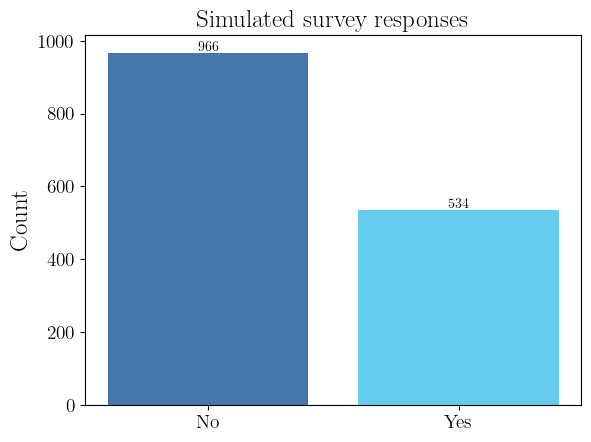

In [4]:
counts = np.array([n - tot, tot])
labels = ["No", "Yes"]

fig, ax = plt.subplots()
bars = ax.bar(labels, counts, color=cl.nbviz.tol_colors(len(labels)))
ax.set_title("Simulated survey responses")
ax.set_ylabel("Count")
for b in bars:
    ax.text(b.get_x() + b.get_width()/2, b.get_height(), f"{int(b.get_height())}",
            ha="center", va="bottom")
plt.show()


## Bernoulli / Binomial model

If each response is Bernoulli,
$$
Y_i \sim \Bern(p),\quad i=1,\dots,n,
$$
then the total number of Yes responses
$$
T=\sum_{i=1}^n Y_i
$$
has a binomial distribution:
$$
T \sim \Bin(n,p).
$$

We estimate $p$with \(\phat = T/n\).

### Standard error (CLT / Normal approximation)

By the Central Limit Theorem, for large \(n\), the sampling distribution of \(\phat\) is approximately normal:
$$
\phat \approx \mathcal{N}\!\left(p,\; \frac{p(1-p)}{n}\right).
$$

Replacing \(p\) with \(\phat\) gives the estimated standard error:
$$
\widehat{\mathrm{SE}}(\phat)=\sqrt{\frac{\phat(1-\phat)}{n}}.
$$


## Confidence intervals

We compute two intervals:

1. **Exact (Binomial) interval** via `scipy.stats.binomtest(...).proportion_ci(...)`
2. **CLT (Normal approximation) interval** (Wald):  
   $$
   \phat \pm \zalpha\sqrt{\frac{\phat(1-\phat)}{n}}.
   $$

> The CLT/Wald interval is simple, but it can behave poorly for small samples or when $\phat$ is very close to 0 or 1.


In [ ]:
# 1) Exact binomial confidence interval (Clopper–Pearson-style)
bt = stats.binomtest(tot, n=n, p=0.5)  # p is irrelevant for the CI call; scipy uses tot,n
ci_exact = bt.proportion_ci(confidence_level=1-alpha, method="exact")

# 2) CLT / Wald interval
z = stats.norm.ppf(1 - alpha/2)
se_hat = math.sqrt(phat * (1 - phat) / n)
ci_clt = (max(0.0, phat - z * se_hat), min(1.0, phat + z * se_hat))

(ci_exact.low, ci_exact.high), ci_clt, z, se_hat


## Report the estimate and intervals

In [ ]:
def fmt_pct(x):
    return f"{100*x:.1f}%"

print(rf"Sample size, $n$ = {n}")
print(f"Yes count = {tot}")
print(f"Point estimate phat = {phat:.4f} ({fmt_pct(phat)})")
print()
print(f"{int((1-alpha)*100)}% exact (binomial) CI: [{ci_exact.low:.4f}, {ci_exact.high:.4f}]  "
      f"= [{fmt_pct(ci_exact.low)}, {fmt_pct(ci_exact.high)}]")
print(f"{int((1-alpha)*100)}% CLT (Wald) CI:       [{ci_clt[0]:.4f}, {ci_clt[1]:.4f}]  "
      f"= [{fmt_pct(ci_clt[0])}, {fmt_pct(ci_clt[1])}]")


## How do the intervals compare?

- The **exact** interval is derived from the binomial model with no normal approximation.
- The **CLT/Wald** interval uses a normal approximation and plugs in \(\phat\) for \(p\).

For moderate to large \(n\) and proportions not near 0 or 1, they are often similar.


In [ ]:
# Optional: Monte Carlo check of approximate coverage (quick demo).
# Increase reps for a more stable estimate.
reps = 2000
p0 = p_true

def ci_exact_for_k(k_):
    bt_ = stats.binomtest(int(k_), n=n, p=0.5)
    ci_ = bt_.proportion_ci(confidence_level=1-alpha, method="exact")
    return (ci_.low, ci_.high)

def ci_clt_for_k(k_):
    ph_ = k_ / n
    se_ = math.sqrt(ph_ * (1 - ph_) / n) if ph_ * (1 - ph_) > 0 else 0.0
    lo = max(0.0, ph_ - z * se_)
    hi = min(1.0, ph_ + z * se_)
    return (lo, hi)

ks = rng.binomial(n=n, p=p0, size=reps)

cover_exact = np.mean([(ci_exact_for_k(k_)[0] <= p0 <= ci_exact_for_k(k_)[1]) for k_ in ks])
cover_clt   = np.mean([(ci_clt_for_k(k_)[0]   <= p0 <= ci_clt_for_k(k_)[1])   for k_ in ks])

print(f"Monte Carlo estimated coverage at p={p0:.3f}, n={n}, reps={reps}:")
print(f"  Exact CI coverage ≈ {cover_exact:.3f}")
print(f"  CLT/Wald coverage ≈ {cover_clt:.3f}")


## Interpreting a confidence interval

A \(95\%\) confidence interval procedure has the property that **in repeated sampling**, about \(95\%\) of the intervals produced will contain the true \(p\).

It does **not** mean: “there is a 95% probability that \(p\) lies in this particular computed interval.”


## Extensions (ideas)

- Explore how the CI width depends on \(n\) (sample size) and \(\phat\).
- Compare additional intervals (Wilson, Agresti–Coull, Jeffreys) and their coverage.
- Discuss survey design: nonresponse, weighting, likely-voter screens, and “margin of error.”
